In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

In [ ]:
import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()

In [ ]:
def VGG16_AvgPool(shape):
  vgg = VGG16(input_shape = shape, weights = 'imagenet', include_top=False)

  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      #replace max pooling with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i,x)

def VGG16_AvgPool_CutOff(shape, num_convs):
  #there are 14 convolutions in total
  #we can pick any of them as the output of our content model
  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range {1,13}")
    return None

  model = VGG16_AvgPool(shape)
  # new_model = Sequential()
  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n+=1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)


In [ ]:
def unpreprocess(img):
  img[...,0] += 103.939
  img[...,1] += 116.779
  img[...,2] += 126.68
  img = img[..., ::-1]

  return img

def scale_img(x):
  x = x-x.min()
  x = x/x.max()
  return x

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 600, 800, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 600, 800, 3), dtype=float32)


iter=0, loss=1052.03759765625
iter=1, loss=511.0978698730469
iter=2, loss=341.73736572265625
iter=3, loss=261.7494201660156
iter=4, loss=216.41400146484375
iter=5, loss=187.12864685058594
iter=6, loss=165.12017822265625
iter=7, loss=149.65298461914062
iter=8, loss=137.5368194580078
iter=9, loss=127.72116088867188
duration:  0:01:05.086552


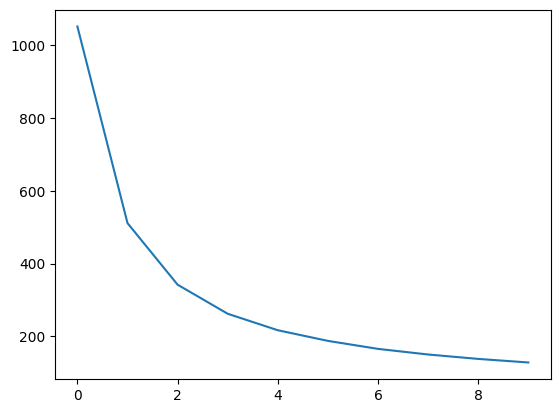

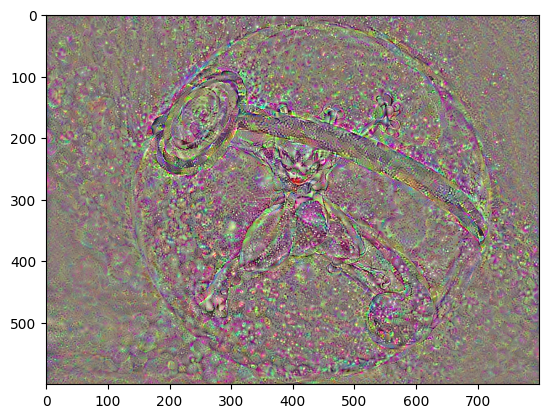

In [ ]:
if __name__ == '__main__':

  path = "/content/mew.jpg"
  img = image.load_img(path)

  #convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x) #preprocess before entering the vgg16

  #we will use this throughtout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]


  content_model = VGG16_AvgPool_CutOff(shape, 11)

  #make the target
  target = K.variable(content_model.predict(x))


  # #define out loss in keras
  loss = K.mean(K.square(target-content_model.output))

  # #gradient
  grads = K.gradients(loss, content_model.input)



  get_loss_and_grads = K.function(
      inputs =[content_model.input],
      outputs = [loss] + grads
  )

  def get_loss_and_grads_wrapper(x_vec):
    '''1D -> 3D'''
    l,g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    '''g.flatten 3D -> 1D'''
    return l.astype(np.float64), g.flatten().astype(np.float64)


  from datetime import datetime
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
        func=get_loss_and_grads_wrapper,
        x0 = x,
        #bounds = [[-127,127]*len(x.flatten())]
        maxfun = 20
    )
    x = np.clip(x, -127,127)

    print("iter=%s, loss=%s" % (i,l))
    losses.append(l)

  print("duration: ", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)

  plt.imshow(scale_img(final_img[0]))
  plt.show()



In [ ]:
def gram_matrix(img):
  #input is (H, W, C) (C = # of feature maps)
  #we need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img,(2,0,1)))

  #calculate the gram matrix
  #gram = XX^T / N
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G

In [ ]:
def style_loss(y,t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [ ]:
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
        func=fn,
        x0 =x, maxfun=20
    )

    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i,l))
    losses.append(l)

  print("duration: ", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)

  return final_img[0]


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_5:0", shape=(None, 512, 512, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_5:0", shape=(None, 512, 512, 3), dtype=float32)


iter=0, loss=14557.162109375
iter=1, loss=432.8125305175781
iter=2, loss=188.53555297851562
iter=3, loss=113.05082702636719
iter=4, loss=78.41153717041016
iter=5, loss=57.27667999267578
iter=6, loss=39.469642639160156
iter=7, loss=29.11229133605957
iter=8, loss=22.739498138427734
iter=9, loss=17.901277542114258
duration:  0:00:44.388730


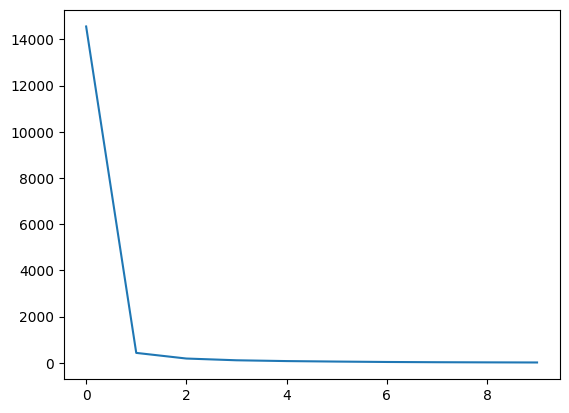

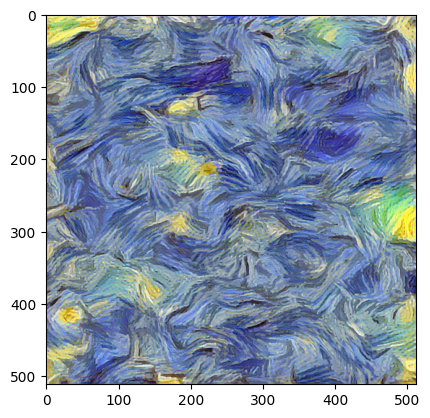

In [ ]:
if __name__ == '__main__':

  path = "/content/style2.png"


  img = image.load_img(path)

  x = image.img_to_array(img)

  x = np.expand_dims(x, axis=0)

  x = preprocess_input(x)
  batch_shape = x.shape
  shape = x.shape[1:]

  vgg = VGG16_AvgPool(shape)


  # note: need to select output at index 1, since outputs at
  # index 0  correspond to the original vgg with maxpool
  symbolic_conv_outputs = [
      layer.get_output_at(1) for layer in vgg.layers \
      if layer.name.endswith("conv1")
  ]

  #symbolic_conv_outputs = symbolic_conv_outputs[:2]

  #make a big model that outputs multiple layers outputs
  multi_output_model = Model(vgg.input, symbolic_conv_outputs) #multiple outputs

  #calculate the targets that are output at each layer
  style_layer_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

  loss = 0
  for symbolic, actual in zip(symbolic_conv_outputs, style_layer_outputs):

    #gram matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

  grads = K.gradients(loss, multi_output_model.input)

  get_loss_and_grads = K.function(
      inputs =[multi_output_model.input],
      outputs = [loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    '''1D -> 3D'''
    l,g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    '''g.flatten 3D -> 1D'''
    return l.astype(np.float64), g.flatten().astype(np.float64)

  final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
  plt.imshow(scale_img(final_img))
  plt.show()


In [ ]:
def load_img_and_preprocess(path, shape = None):
  img = image.load_img(path, target_size=shape)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_8:0", shape=(None, 600, 800, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_8:0", shape=(None, 600, 800, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_8:0", shape=(None, 600, 800, 3), dtype=float32)


iter=0, loss=41342.83203125
iter=1, loss=2128.923828125
iter=2, loss=1318.8707275390625
iter=3, loss=1009.3728637695312
iter=4, loss=839.707763671875
iter=5, loss=730.94189453125
iter=6, loss=645.1505737304688
iter=7, loss=577.9777221679688
iter=8, loss=533.7423706054688
iter=9, loss=493.5639953613281
iter=10, loss=462.5583190917969
iter=11, loss=436.1929016113281
iter=12, loss=415.0898132324219
iter=13, loss=391.8826599121094
iter=14, loss=376.3739013671875
iter=15, loss=363.6705627441406
iter=16, loss=350.5811462402344
iter=17, loss=340.74859619140625
iter=18, loss=331.1586608886719
iter=19, loss=323.8920593261719
iter=20, loss=316.7725524902344
iter=21, loss=310.70062255859375
iter=22, loss=305.1971130371094
iter=23, loss=300.4929504394531
iter=24, loss=295.84515380859375
iter=25, loss=291.50811767578125
iter=26, loss=288.1744079589844
iter=27, loss=284.5910949707031
iter=28, loss=281.4125671386719
iter=29, loss=278.3713073730469
iter=30, loss=275.9133605957031
iter=31, loss=273.371

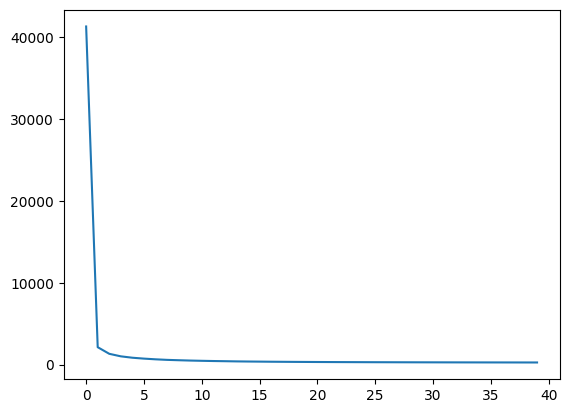

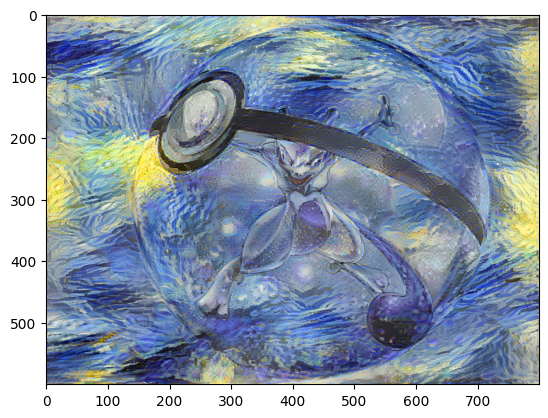

In [ ]:
content_img = load_img_and_preprocess(
    "/content/mew.jpg"
)

h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
    "/content/style2.png",
    (h,w)
)

# to use within the script
batch_shape = content_img.shape
shape = content_img.shape[1:]

# we want to create only one vgg here
vgg = VGG16_AvgPool(shape)

# create the content model
content_model = Model(vgg.input, vgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))


# create the style model
# we want multiple outputs
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith("conv1")
]

# model that outputs multiple layers
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layer_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [1,2,3,4,5] # this is like beta


#create the total loss which is the sume of the content +style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in  zip(style_weights, symbolic_conv_outputs,
                                style_layer_outputs):
  loss += w * style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, vgg.input)

get_loss_and_grads = K.function(
    inputs=[vgg.input],
    outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
  '''1D -> 3D'''
  l,g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  '''g.flatten 3D -> 1D'''
  return l.astype(np.float64), g.flatten().astype(np.float64)

final_img = minimize(get_loss_and_grads_wrapper, 40, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()
